<a href="https://colab.research.google.com/github/juanmed/drake_tutorial/blob/main/ComputePenetrationExtentField.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

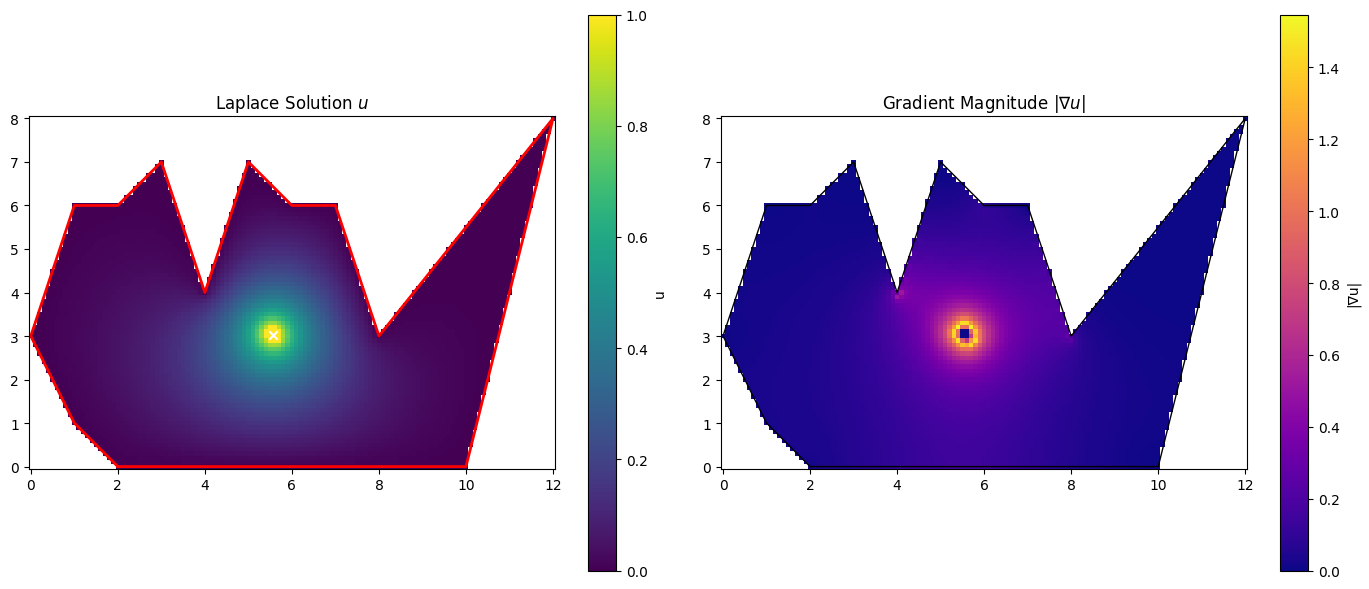

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def generate_grid(polygon, dx, dy):
    minx, miny, maxx, maxy = polygon.bounds
    x = np.arange(minx, maxx + dx, dx)
    y = np.arange(miny, maxy + dy, dy)
    grid_x, grid_y = np.meshgrid(x, y)

    inside_mask = np.array([[polygon.contains(Point(xi, yi)) or polygon.touches(Point(xi, yi))
                             for xi in x] for yi in y])
    return x, y, grid_x, grid_y, inside_mask

def laplace_solver(x, y, inside_mask, polygon, centroid_value=1.0, centroid_radius=0.2):
    ny, nx = inside_mask.shape
    N = nx * ny
    index_map = -np.ones_like(inside_mask, dtype=int)
    idx = 0
    for j in range(ny):
        for i in range(nx):
            if inside_mask[j, i]:
                index_map[j, i] = idx
                idx += 1

    A = lil_matrix((idx, idx))
    b = np.zeros(idx)

    centroid = polygon.centroid
    cx, cy = centroid.x, centroid.y

    for j in range(ny):
        for i in range(nx):
            if not inside_mask[j, i]:
                continue

            xi, yj = x[i], y[j]
            row = index_map[j, i]
            point = Point(xi, yj)

            if polygon.exterior.distance(point) < 1e-10:
                A[row, row] = 1.0
                b[row] = 0.0
            elif point.distance(centroid) < centroid_radius:
                A[row, row] = 1.0
                b[row] = centroid_value
            else:
                A[row, row] = -4
                for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < nx and 0 <= nj < ny and inside_mask[nj, ni]:
                        col = index_map[nj, ni]
                        A[row, col] = 1
                    else:
                        b[row] -= 0

    u = np.zeros(N)
    u_flat = spsolve(A.tocsr(), b)
    for j in range(ny):
        for i in range(nx):
            if inside_mask[j, i]:
                u[j * nx + i] = u_flat[index_map[j, i]]
    u_grid = u.reshape((ny, nx))

    # Compute gradients
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    du_dx, du_dy = np.gradient(u_grid, dx, dy)

    return u_grid, du_dx, du_dy

def plot_solution(x, y, u, du_dx, du_dy, inside_mask, polygon):
    grad_mag = np.sqrt(du_dx**2 + du_dy**2)
    masked_u = np.ma.array(u, mask=~inside_mask)
    masked_grad = np.ma.array(grad_mag, mask=~inside_mask)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot solution
    ax = axs[0]
    c0 = ax.pcolormesh(x, y, masked_u, shading='auto', cmap='viridis', vmin=0, vmax=1)
    ax.set_title('Laplace Solution $u$')
    x_poly, y_poly = polygon.exterior.xy
    ax.plot(x_poly, y_poly, color='red', linewidth=2)
    ax.scatter(*polygon.centroid.xy, color='white', marker='x', label='Centroid')
    ax.set_aspect('equal')
    fig.colorbar(c0, ax=ax, label='u')

    # Plot gradient magnitude
    ax = axs[1]
    c1 = ax.pcolormesh(x, y, masked_grad, shading='auto', cmap='plasma')
    ax.set_title('Gradient Magnitude $|\\nabla u|$')
    ax.plot(x_poly, y_poly, color='black', linewidth=1)
    ax.set_aspect('equal')
    fig.colorbar(c1, ax=ax, label='|∇u|')

    plt.tight_layout()
    plt.show()


# Stylized turtle shape
turtle_coords = [
    (2, 0), (1, 1), (0, 3), (1, 6), (2, 6), (3, 7),
    (4, 4), (5, 7), (6, 6), (7, 6), (8, 3), (12, 8), (10, 0), (2, 0)
]

polygon = Polygon(turtle_coords)
dx = dy = 0.1

x, y, grid_x, grid_y, inside_mask = generate_grid(polygon, dx, dy)
u, du_dx, du_dy = laplace_solver(x, y, inside_mask, polygon)
plot_solution(x, y, u, du_dx, du_dy, inside_mask, polygon)
